# File Creater for the TOLIMAN Pupil

Install necessary packages

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as np

import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT
import OpticsSupport
import PlottingSupport
import STLMaker
import math

In [2]:
psf_flag = False
create_cutout = False
make_stl = False

## Parameters

In [3]:
# Aperture parameters
ratio = 1                           # Ratio to scale the aperture by (e.g. 5 = 5-inch aperture becomes 1-inch aperture)
aperture_npix = 1000                # Number of pixels across the aperture
aperture_diameter = 0.125/ratio     # Clear aperture diameter (m)
secondary_diameter = 0.032/ratio    # Secondary mirror diameter (m)
spider_width       = 0.002/ratio    # Spider width (m)

# Observations wavelegths (bandpass of 530-640nm)
wavelengths = np.linspace(530e-9, 640e-9, 100)  # Wavelengths to simulate (m)

# Subtrate parameters
n1 = 1          # Refractive index of free space
n2 = 1.5424     # Refractive index of Zerodur

# Mask
mask_path = 'diffractive_pupil.npy'
phase_mask = np.load(mask_path) * np.pi     # Load the mask and convert to phase

# Grating parameters
amplitude = 375e-9                          # Amplitude of the grating (m). Peak to peak amplitude of the grating etched in the glass
det_npixels = 2048                          # DO NOT TOUCH
pixel_scale = dlu.arcsec2rad(0.375)*ratio   # 0.375 arcsec per pixel
max_reach = 0.8                             # Max wavelength to diffract to 80% of the diagonal length of the detector

## Create the mask

In [4]:
# Make the mask
mask, raw_mask, X, Y = OpticsSupport.HelperFunctions.make_grating_mask(phase_mask, aperture_npix, aperture_diameter, secondary_diameter, spider_width, wavelengths, amplitude, det_npixels, pixel_scale, max_reach, n1, n2, out = 0., apply_spiders=False, return_raw=True)

Grating amplitude: 2.4308559894561768
Nyquist Ratio: 1.2154279947280884
Grating period: 0.000303856999380514m


Plot mask to check correct pattern and resolution

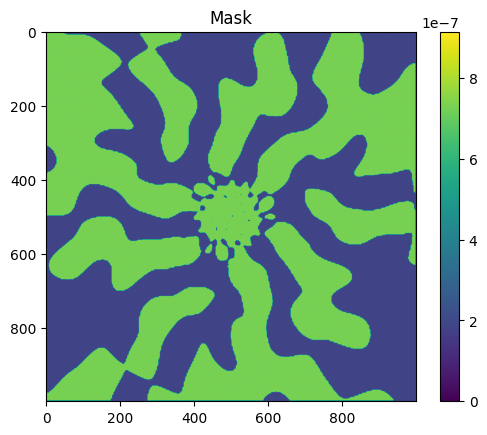

In [5]:
PlottingSupport.Plotting.printColormap(mask, title="Mask", colorbar=True, colormap="viridis")

Create the phase mask and the instrument

In [6]:
wf_npixels = aperture_npix                                  # Number of pixels across the wavefront
peak_wavelength = np.mean(wavelengths)                      # Peak wavelength of the bandpass (m)

# Create Telescope
phase_mask = OpticsSupport.HelperFunctions.createPhaseMask(raw_mask, peak_wavelength, n1, n2)  # Create the phase mask
mask = dl.Optic(phase=phase_mask)
optics = dlT.TolimanOpticalSystem(wf_npixels=wf_npixels, mask=mask, psf_npixels=det_npixels, oversample=1)
source = dlT.AlphaCen(n_wavels=100, separation=8, position_angle=30)
instrument = OpticsSupport.HelperFunctions.createTolimanTelescope(optics, source, ratio)


In [7]:
optics

TolimanOpticalSystem(
  wf_npixels=1000,
  diameter=0.125,
  layers={
    'aperture':
    TransmissiveLayer(transmission=f32[1000,1000], normalise=True),
    'pupil':
    Optic(opd=None, phase=f32[1000,1000], transmission=None, normalise=False)
  },
  psf_npixels=2048,
  oversample=1,
  psf_pixel_scale=0.375
)

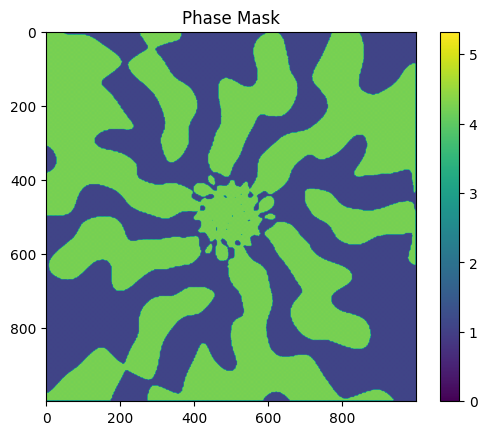

In [8]:
PlottingSupport.Plotting.printColormap(phase_mask, title="Phase Mask", colorbar=True, colormap="viridis")

Simulate the PSF

In [9]:
# Create PSF
if psf_flag:
    psf = instrument.model()

Display the PSF

In [10]:
if psf_flag:
    r = psf.shape[0]
    c = r//2
    s = 64

    central_psf = psf[c-s:c+s, c-s:c+s]
    sidelobe_psf = psf[r//12:r//12+r//10,r//12:r//12+r//10]
    PlottingSupport.Plotting.printColormap(psf**0.2, title="PSF", colorbar=True)
    PlottingSupport.Plotting.printColormap(central_psf, title="PSF Central", colorbar=True)
    print(f"Central Flux: {(np.sum(central_psf)/np.sum(psf))*100:.2f}%")
    PlottingSupport.Plotting.printColormap(sidelobe_psf, title="PSF Sidelobe", colorbar=True)
    print(f"Sidelobe Flux: {(np.sum(sidelobe_psf)/np.sum(psf))*4*100:.2f}%")

### Elevating the phase mask

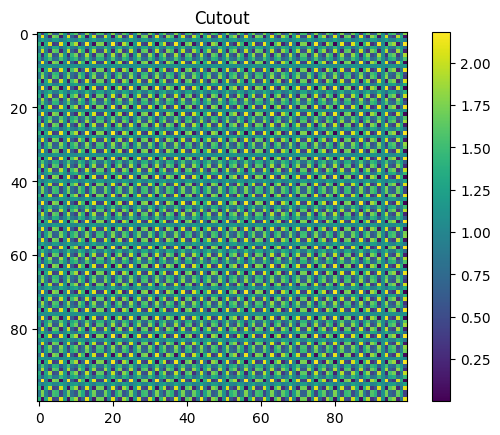

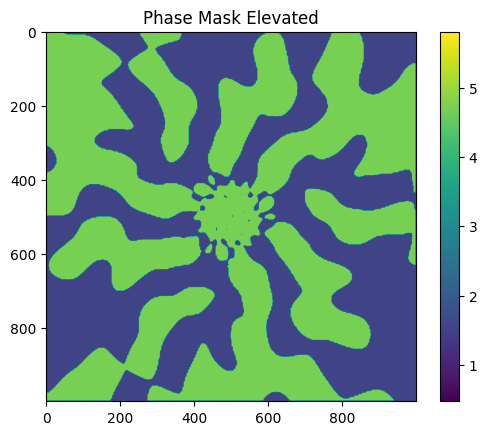

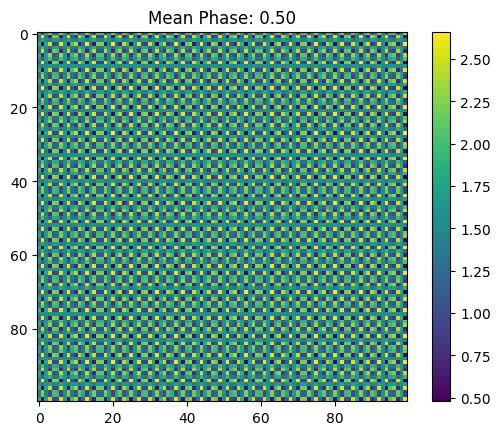

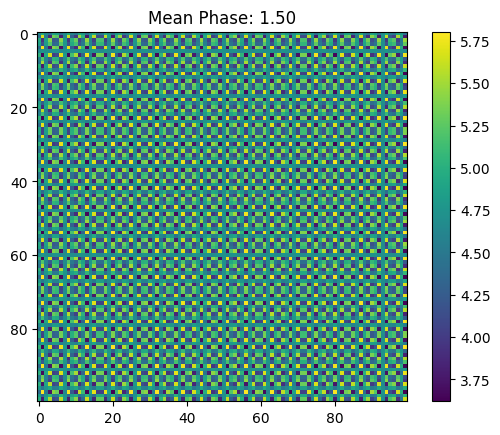

In [11]:
# Defining cutout areas
x_min = int((0/5)*aperture_npix)
x_max = int((0.5/5)*aperture_npix)
y_low_min = int((3.6/5)*aperture_npix)
y_low_max = int((4.1/5)*aperture_npix)
y_high_min = int((0.5/5)*aperture_npix)
y_high_max = int((1/5)*aperture_npix)

# Cutout a lower section and elevate so the average is at 0.5π and 1.5π for the two steps
cutout = phase_mask[y_low_min:y_low_max,x_min:x_max]
PlottingSupport.Plotting.printColormap(cutout, title="Cutout", colorbar=True, colormap="viridis")
cutout_mean = np.mean(cutout)
elevation = (0.5*np.pi - cutout_mean)
phase_mask_elevated = phase_mask + elevation
PlottingSupport.Plotting.printColormap(phase_mask_elevated, title="Phase Mask Elevated", colorbar=True, colormap="viridis")

# Check lower section
low_cutout_elevated = phase_mask_elevated[y_low_min:y_low_max,x_min:x_max]
cutout_low_mean_phase = np.mean(low_cutout_elevated)/np.pi
PlottingSupport.Plotting.printColormap(low_cutout_elevated, title=f"Mean Phase: {cutout_low_mean_phase:.2f}", colorbar=True, colormap="viridis")

if not math.isclose(0.5,cutout_low_mean_phase,rel_tol=1e-2):
    raise Exception(f"Low cutout not at 0.5: {cutout_low_mean_phase:.5f}")

# Check higher section
high_cutout_elevated = phase_mask_elevated[y_high_min:y_high_max,x_min:x_max]
cutout_high_mean_phase = np.mean(high_cutout_elevated)/np.pi
PlottingSupport.Plotting.printColormap(high_cutout_elevated, title=f"Mean Phase: {cutout_high_mean_phase:.2f}", colorbar=True, colormap="viridis")

if not math.isclose(1.5,cutout_high_mean_phase,rel_tol=1e-2):
    raise Exception(f"High cutout not at 1.5: {cutout_high_mean_phase:.5f}")

Calculate phase amplitude

In [12]:
p2p = (low_cutout_elevated.max()- low_cutout_elevated.min())/(2*np.pi)
print(f'Single sinusoid p2p: {p2p: .3f}\u03C0')


Single sinusoid p2p:  0.348π


Make a circular cutout

In [17]:
scale = 0.2
x_centre = int((4/5)*aperture_npix)
y_centre = int((2.6/5)*aperture_npix)
circle_cutout_region = (int((4/5)*aperture_npix),int((2.6/5)*aperture_npix))   

if create_cutout:
    inch_cutout = OpticsSupport.HelperFunctions.createCircularCutout(scale, circle_cutout_region, aperture_npix)

    inch_cutout_elevated_phase_mask = (phase_mask+elevation) * inch_cutout
    PlottingSupport.Plotting.printColormap(inch_cutout_elevated_phase_mask, title="Inch Cutout Mask", colorbar=True, colormap="viridis")

    radius = int(aperture_npix * 0.2 / 2)
    zoom = inch_cutout_elevated_phase_mask[(y_centre-radius):(y_centre+radius),(x_centre-radius):(x_centre+radius)]
    PlottingSupport.Plotting.printColormap(zoom, title="Inch Cutout Zoom", colorbar=True, colormap="viridis")

    plt.imsave('Generated Files/Images/inch_cutout.png', zoom)
    np.save('Generated Files/Engineering/inch_cutout.npy', zoom)

Cutout the shape of the telescope

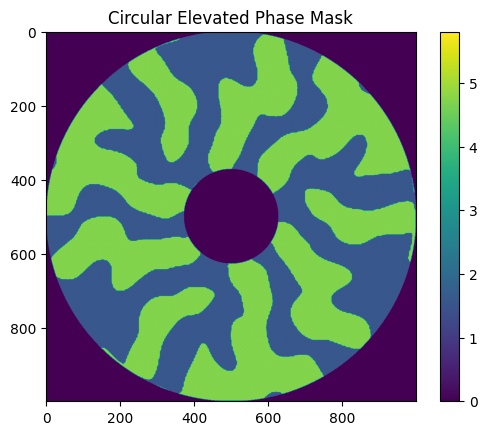

In [14]:
circular_mask_outer = OpticsSupport.HelperFunctions.createCircularMask(aperture_npix,aperture_npix, radius=aperture_npix/2)
inner_r = (aperture_npix*(secondary_diameter/aperture_diameter))/2
circular_mask_inner = 1 - OpticsSupport.HelperFunctions.createCircularMask(aperture_npix,aperture_npix, radius=inner_r)
circular_mask = circular_mask_outer & circular_mask_inner

circular_elevated_phase_mask = (phase_mask+elevation) * circular_mask
PlottingSupport.Plotting.printColormap(circular_elevated_phase_mask, title="Circular Elevated Phase Mask", colorbar=True, colormap="viridis")

Convert the mask to a bitmap (adding to make mean pi)

In [22]:
np.save('Generated Files/Engineering/new_diffractive_pupil.npy', circular_elevated_phase_mask)
plt.imsave('Generated Files/Images/new_diffractive_pupil.png', circular_elevated_phase_mask)

In [16]:
if make_stl==True:
    mask = circular_elevated_phase_mask
    STLMaker.Mesh2STL.mesh_to_stl(X, Y, mask, aperture_npix, 'Generated Files/Engineering/test_file_m', unit_in='m', unit_out='m', binary=True)
    STLMaker.Mesh2STL.mesh_to_stl(X, Y, mask, aperture_npix, 'Generated Files/Engineering/test_file_mm', unit_in='m', unit_out='mm', binary=True)
    STLMaker.Mesh2STL.mesh_to_stl(X, Y, mask, aperture_npix, 'Generated Files/Engineering/test_file_um', unit_in='m', unit_out='um', binary=True)
    STLMaker.Mesh2STL.mesh_to_stl(X, Y, mask, aperture_npix, 'Generated Files/Engineering/test_file_nm', unit_in='m', unit_out='nm', binary=True)